<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [0]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
cd /content/gdrive/My\ Drive/Colab\ Notebooks/HW4

/content/gdrive/My Drive/Colab Notebooks/HW4


In [0]:
 #!tar xzvf handout.tar.gz

### Data preprocessing

In [0]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 221 ms, sys: 1.19 s, total: 1.41 s
Wall time: 15.6 s


In [0]:
captions

[['people shopping in an open market for vegetables .',
  'an open market full of people and piles of vegetables .',
  'people are shopping at an open air produce market .',
  'large piles of carrots and potatoes at a crowded outdoor market .',
  'people shop for vegetables like carrots and potatoes at an open air market .'],
 ['a person skiing down a steep hill',
  'a person skiing down a steep snowy hill .',
  'a person on snow skis going down a steep slope .',
  'a skier is skiing down a down hill slope .',
  'a skier is shown taking on a very steep slope .'],
 ['the black and white dog stands near a person holding a frisbee .',
  'a dog is looking at a blue frisbee .',
  'a dog watches a person who is holding a frisbee .',
  'a dog looking at a man holding a frisbee with another dog laying down .',
  'a couple of dogs that are in a grassy field'],
 ['the skateboarder is putting on a show using the picnic table as his stage .',
  'a skateboarder pulling tricks on top of a picnic tab

### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [0]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]: 
          word_counts[word] += 1 
print('Finished!')

Finished!


In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size=lstm_units, batch_first=True,)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(lstm_units, n_tokens))
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))

        # compute logits from lstm_out
        logits = self.logits(lstm_out[0])
        
        return logits        

In [0]:
network = CaptionNet(n_tokens)
network.cuda()

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=256, out_features=10403, bias=True)
  )
)

In [0]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)
dummy_logits = network.forward(dummy_img_vec.cuda(), dummy_capt_ix.cuda())

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
   
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    #print(captions_ix_next)
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors.cuda(), captions_ix_inp.cuda())
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    #print(network.forward(image_vectors, captions_ix_next).shape)
    #print(logits_for_next.shape)
    
    
    loss_function = nn.CrossEntropyLoss(ignore_index=pad_ix)
    
    logits_for_next_reshaped = logits_for_next.view((logits_for_next.shape[0]*logits_for_next.shape[1], -1))
    

    captions_ix_next_reshaped = captions_ix_next.view(-1)

    loss = loss_function(logits_for_next_reshaped.cuda(), captions_ix_next_reshaped.cuda())
    #print(torch.unsqueeze(loss, dim=0).shape)
    return torch.unsqueeze(loss, dim=0)

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec.cuda(), dummy_capt_ix.cuda())

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [0]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,250,400], gamma=0.1)

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[
        random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [0]:
generate_batch(img_codes,captions,3)

(tensor([[0.1468, 0.2215, 0.5824,  ..., 0.1530, 0.4536, 0.0000],
         [0.0286, 0.2202, 0.1321,  ..., 0.3908, 0.3505, 0.4082],
         [0.6140, 0.1571, 0.9545,  ..., 0.0103, 0.6883, 0.8680]]),
 tensor([[   1,   24,  658,   14, 6675,   99,  161,   24,  326,   35,   24,  291,
            12,    2,    3,    3],
         [   1,   24,  158,   58,   24,  874,  243,   15,   24, 3518,  482,  309,
           557,  156,   12,    2],
         [   1,   88,   92,   63,   17,    6,   24, 9453,  123,  319,   41,    6,
            24,  157, 2201,    2]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
batch_size = 100  # adjust me
n_epochs = 2000  # adjust me
n_batches_per_epoch = 100 # adjust me
n_validation_batches = 10  # how many batches are used for validation after each epoch

In [0]:
from tqdm import tqdm

network.cuda()
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss_t.item()
    #scheduler.step()   
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    
    if epoch%100 == 0:
      torch.save(network.state_dict(), 'model_final_saved_'+str(epoch)+'.pt')

print("Finished!")
torch.save(network.state_dict(), 'model_final_saved_end.pt')


Epoch: 0, train loss: 2.164761723279953, val loss: 2.3698516845703126

Epoch: 1, train loss: 2.1699940359592436, val loss: 2.428799295425415

Epoch: 2, train loss: 2.164632248878479, val loss: 2.4089961528778074

Epoch: 3, train loss: 2.161367199420929, val loss: 2.458731842041016

Epoch: 4, train loss: 2.16419237613678, val loss: 2.3905307054519653

Epoch: 5, train loss: 2.172418158054352, val loss: 2.4325949430465696

Epoch: 6, train loss: 2.148278434276581, val loss: 2.409505772590637

Epoch: 7, train loss: 2.1783159053325654, val loss: 2.3856350660324095

Epoch: 8, train loss: 2.178892824649811, val loss: 2.4435067176818848

Epoch: 9, train loss: 2.180796941518784, val loss: 2.4067261934280397

Epoch: 10, train loss: 2.1767464792728424, val loss: 2.498189902305603

Epoch: 11, train loss: 2.165811550617218, val loss: 2.392105460166931

Epoch: 12, train loss: 2.1687509489059447, val loss: 2.4996365308761597

Epoch: 13, train loss: 2.169797885417938, val loss: 2.448306703567505

Epoc

KeyboardInterrupt: ignored

In [0]:
torch.save(network.state_dict(), 'model_saved_1500_pretty_good.pt')

In [0]:
#network = torch.load('model_saved_900.pt')
network.load_state_dict(torch.load('model_saved_1100_pretty_good.pt'))
network.cuda()

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=256, out_features=10403, bias=True)
  )
)

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [0]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck.cuda(), prefix_ix.cuda())[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.cpu().numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [0]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2019-05-16 15:43:43--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.52.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.52.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105.40K  --.-KB/s    in 0.02s   

2019-05-16 15:43:43 (4.47 MB/s) - ‘data/img.jpg’ saved [107928/107928]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


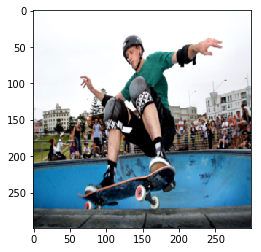

In [0]:
plt.imshow(img)

In [0]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is doing tricks on a skateboard .
a man riding a skateboard down a ramp .
a skateboarder flips his board on a skate ramp .
a man riding a skateboard up the side of a ramp .
a man on a skateboard doing a trick on a rail .
a skateboarder is doing a trick in the air .
a skateboarder is doing a trick in the air .
a man is doing a trick on a skateboard .
a skateboarder is doing a trick in the air .
a man riding a skateboard on top of a ramp .


--2019-05-16 15:44:15--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.02s   

2019-05-16 15:44:15 (4.75 MB/s) - ‘data/img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


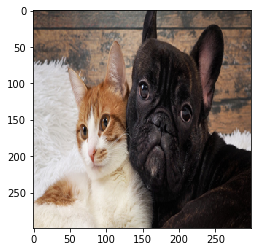

a cat is laying on a bed with a tag on its head .
a cat laying on a bed with a hat .
a cat is laying on a bed with a blanket .
a cat is sitting on a couch with a remote .
a cat is laying on a bed .
a cat is sitting on a couch with a remote control .
a cat sitting on a chair with a hat on .
a cat is laying on a bed with a blanket .
a dog is laying down with a book and a cat on the back .
a cat is sitting on a couch with a book .


In [0]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

--2019-05-16 15:51:05--  http://www.makeitinny.com/wp-content/uploads/2016/04/%D0%B8%D0%B3%D1%80%D0%B0-%D0%BF%D1%80%D0%B5%D1%81%D1%82%D0%BE%D0%BB%D0%BE%D0%B2-%D1%81-%D0%BC%D0%B8%D0%BD%D0%B8-2.jpg
Resolving www.makeitinny.com (www.makeitinny.com)... 162.241.132.110
Connecting to www.makeitinny.com (www.makeitinny.com)|162.241.132.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102256 (100K) [image/jpeg]
Saving to: ‘игра-престолов-с-мини-2.jpg.1’

игра-престолов-с-ми 100%[===================>]  99.86K   421KB/s    in 0.2s    

2019-05-16 15:51:05 (421 KB/s) - ‘игра-престолов-с-мини-2.jpg.1’ saved [102256/102256]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


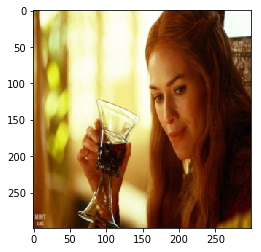

a woman sitting at a table with a glass of wine .
a woman sitting in front of a glass of wine .
a woman holding a glass of wine and a glass of wine .
a woman sitting at a table with a glass of wine .
a woman with glasses and a wine glass
a woman holding a glass of wine .
a woman is holding a glass of wine .
a woman sitting at a table with a glass of wine .
a woman is holding a glass of wine .
a man and a woman are having a conversation .


In [0]:
!wget http://www.makeitinny.com/wp-content/uploads/2016/04/%D0%B8%D0%B3%D1%80%D0%B0-%D0%BF%D1%80%D0%B5%D1%81%D1%82%D0%BE%D0%BB%D0%BE%D0%B2-%D1%81-%D0%BC%D0%B8%D0%BD%D0%B8-2.jpg
img = plt.imread('игра-престолов-с-мини-2.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Okay, let's start from something actual and pretty simple. Cersei with glass of wine (hahah, classic), network  сoped with it pretty well. The last prediction most probably is mistake, but very funny that in this moment in the episode she actual was talking to Tyrion :D.

--2019-05-16 15:47:41--  https://s11.stc.all.kpcdn.net/share/i/12/10522907/inx960x640.jpg
Resolving s11.stc.all.kpcdn.net (s11.stc.all.kpcdn.net)... 192.240.115.54
Connecting to s11.stc.all.kpcdn.net (s11.stc.all.kpcdn.net)|192.240.115.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179359 (175K) [image/jpeg]
Saving to: ‘inx960x640.jpg’

inx960x640.jpg      100%[===================>] 175.16K   594KB/s    in 0.3s    

2019-05-16 15:47:42 (594 KB/s) - ‘inx960x640.jpg’ saved [179359/179359]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


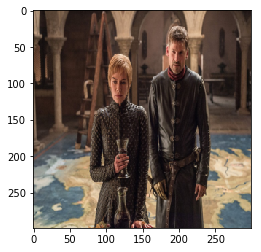

a man and woman standing next to each other holding hands .
a woman with a tie and a black and white bag
a woman and a woman are standing in a store .
a woman is standing in front of a display of people .
a woman in a dress shirt holding a cell phone .
a woman in a dress dress and a man in a dress and tie
a woman and a man are standing together .
a man and woman standing in front of a table with a cake .
a man and woman standing in a store .
a group of people standing around a wooden table .


In [0]:
!wget https://s11.stc.all.kpcdn.net/share/i/12/10522907/inx960x640.jpg
img = plt.imread('inx960x640.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Let's go further, and also good result prediction. ''A man and woman standing in front of a table with a cake" is just the truth.

--2019-05-16 15:45:08--  https://image.freepik.com/free-photo/man-playing-guitar-his-beautiful-wife-home_23-2147892086.jpg
Resolving image.freepik.com (image.freepik.com)... 184.27.37.251, 2600:1406:e800:49e::30ec, 2600:1406:e800:487::30ec
Connecting to image.freepik.com (image.freepik.com)|184.27.37.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158948 (155K) [image/jpeg]
Saving to: ‘man-playing-guitar-his-beautiful-wife-home_23-2147892086.jpg.18’

man-playing-guitar- 100%[===================>] 155.22K  --.-KB/s    in 0.04s   

2019-05-16 15:45:09 (3.79 MB/s) - ‘man-playing-guitar-his-beautiful-wife-home_23-2147892086.jpg.18’ saved [158948/158948]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


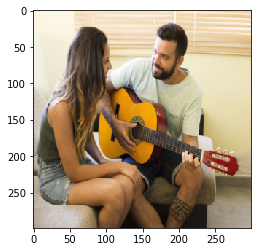

planters sitting on a bench with a man in background .
a woman is sitting on a bench with a suitcase .
a man is sitting on a bench with a guitar .
a man is sitting on a couch with a guitar .
a woman is sitting on a bench with a guitar .
a man is holding a banana in his hand .
a man is sitting on a couch with a guitar .
a man with a guitar on his head with a skateboard .
a man with a backpack and a guitar on a cell phone .
a man is sitting on a bench with a suitcase .


In [0]:
!wget https://image.freepik.com/free-photo/man-playing-guitar-his-beautiful-wife-home_23-2147892086.jpg
img = plt.imread('man-playing-guitar-his-beautiful-wife-home_23-2147892086.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

This time we took something more complex. Ideal prediction should be something like "man with guitar is sitting on a couch next to the woman", but we have both this parts separatly. We have "woman that sitting on the bench with guitar" and "a man is sitting on a couch with a guitar". Not so good as I expected, but since good enough.

--2019-05-16 15:45:59--  https://www.featurepics.com/StockImage/20130725/man-playing-guitar-stock-image-2753315.jpg
Resolving www.featurepics.com (www.featurepics.com)... 207.111.203.211
Connecting to www.featurepics.com (www.featurepics.com)|207.111.203.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191225 (187K) [image/jpeg]
Saving to: ‘man-playing-guitar-stock-image-2753315.jpg.6’

man-playing-guitar- 100%[===================>] 186.74K  --.-KB/s    in 0.1s    

2019-05-16 15:46:00 (1.77 MB/s) - ‘man-playing-guitar-stock-image-2753315.jpg.6’ saved [191225/191225]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


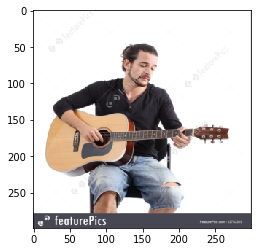

a man and woman sitting on a bench .
a man is sitting on a bench with a guitar .
a man sitting on a bench with a guitar .
a man sitting on a bench with a guitar .
a man sitting on a bench with a guitar
a man in a suit and a guitar case
a man sitting on a bench with a guitar .
a man sitting on a bench with a guitar .
a couple of people sitting on top of a bench .
a man sitting on a bench with a guitar


In [0]:
!wget https://www.featurepics.com/StockImage/20130725/man-playing-guitar-stock-image-2753315.jpg
img = plt.imread('man-playing-guitar-stock-image-2753315.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

It's good enough.

--2019-05-16 16:09:22--  https://st3.depositphotos.com/1178490/15942/i/1600/depositphotos_159423402-stock-photo-woman-walking-in-park-with.jpg
Resolving st3.depositphotos.com (st3.depositphotos.com)... 104.115.133.161
Connecting to st3.depositphotos.com (st3.depositphotos.com)|104.115.133.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478350 (467K) [image/jpeg]
Saving to: ‘depositphotos_159423402-stock-photo-woman-walking-in-park-with.jpg’

depositphotos_15942 100%[===================>] 467.14K   176KB/s    in 2.7s    

2019-05-16 16:09:26 (176 KB/s) - ‘depositphotos_159423402-stock-photo-woman-walking-in-park-with.jpg’ saved [478350/478350]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


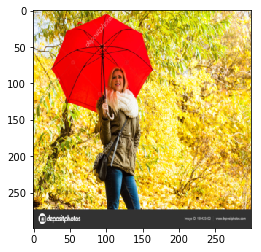

a woman with a red umbrella is walking down the street .
a woman holding a pink umbrella in the rain .
a woman walking down a street with an umbrella .
a woman holding a yellow umbrella in the rain .
a woman with an umbrella standing on a sidewalk .
a woman with a red umbrella is standing in the rain .
a woman holding a pink umbrella in the rain .
a woman holding a red umbrella in the rain .
a woman standing on a beach with a red umbrella .
a woman is holding an umbrella in the rain .


In [0]:
!wget https://st3.depositphotos.com/1178490/15942/i/1600/depositphotos_159423402-stock-photo-woman-walking-in-park-with.jpg
img = plt.imread('depositphotos_159423402-stock-photo-woman-walking-in-park-with.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Also something simple and good enough. First prediction is pretty well.

--2019-05-16 16:13:15--  https://image.freepik.com/free-photo/_23-2147899760.jpg
Resolving image.freepik.com (image.freepik.com)... 184.27.37.251, 2600:1409:12:290::30ec, 2600:1409:12:286::30ec
Connecting to image.freepik.com (image.freepik.com)|184.27.37.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182209 (178K) [image/jpeg]
Saving to: ‘_23-2147899760.jpg’

_23-2147899760.jpg  100%[===================>] 177.94K   624KB/s    in 0.3s    

2019-05-16 16:13:15 (624 KB/s) - ‘_23-2147899760.jpg’ saved [182209/182209]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


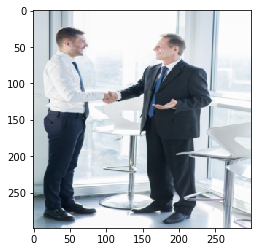

a man wearing a suit and tie standing next to a woman .
a man in a suit and tie standing next to a woman .
a man in a suit and tie with a tie on .
a man in a suit and tie with a tie in his hand .
a man wearing a suit and tie with a tie
a man in a suit and tie with a tie in front of him .
a man in a suit and tie standing next to a man in a suit .
a man wearing a suit and tie standing next to a woman .
a man and woman standing in front of a building .
a man in a suit with a tie on .


In [0]:
!wget https://image.freepik.com/free-photo/_23-2147899760.jpg
img = plt.imread('_23-2147899760.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

This time, network understood that "a man in a suit and tie standing next to a man in a suit ", but I actually hoped that it will see a handshake between them. Good enough, but not so good as I expected.

--2019-05-16 15:46:32--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRHnuQUyMipN0UJ0Pk37miY_lMUOc-LnBSRDVNTjtkLgVtM_L8V
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.195.102, 74.125.195.138, 74.125.195.113, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12814 (13K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcRHnuQUyMipN0UJ0Pk37miY_lMUOc-LnBSRDVNTjtkLgVtM_L8V.18’

images?q=tbn:ANd9Gc 100%[===================>]  12.51K  --.-KB/s    in 0.004s  

2019-05-16 15:46:32 (3.29 MB/s) - ‘images?q=tbn:ANd9GcRHnuQUyMipN0UJ0Pk37miY_lMUOc-LnBSRDVNTjtkLgVtM_L8V.18’ saved [12814/12814]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


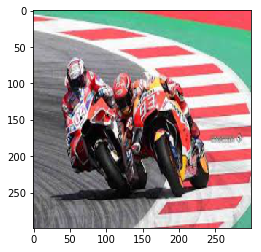

a person riding a motorcycle on a blue surface
a motorcycle parked on a snowy surface with a helmet on .
a person on a motorcycle with a helmet on .
a person riding a motorcycle with a helmet on .
a person on a motorcycle with a helmet on .
a person riding a snowboard on a snowy surface
a motorcycle with a helmet on it is on the ground .
a person riding a motorcycle on a beach .
a person is riding a motorcycle on a dirt surface
a motorcycle racer with a blue helmet on his head .


In [0]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRHnuQUyMipN0UJ0Pk37miY_lMUOc-LnBSRDVNTjtkLgVtM_L8V
img = plt.imread('images?q=tbn:ANd9GcRHnuQUyMipN0UJ0Pk37miY_lMUOc-LnBSRDVNTjtkLgVtM_L8V')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Network coped pretty well. But I hoped that it will see two motorcycles and two men here. I thing that problem occured because both figures here merged into one. But since result is satisfying me.

--2019-05-16 15:24:31--  http://www.naijaloaded.com.ng/wp-content/uploads/2015/09/woman-fighting-man.jpg
Resolving www.naijaloaded.com.ng (www.naijaloaded.com.ng)... 104.25.39.7, 104.25.38.7
Connecting to www.naijaloaded.com.ng (www.naijaloaded.com.ng)|104.25.39.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45475 (44K) [image/jpeg]
Saving to: ‘woman-fighting-man.jpg.17’

woman-fighting-man. 100%[===================>]  44.41K  --.-KB/s    in 0.004s  

2019-05-16 15:24:32 (10.9 MB/s) - ‘woman-fighting-man.jpg.17’ saved [45475/45475]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


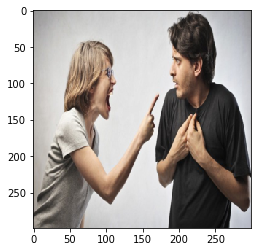

a man and woman are brushing their teeth .
a man is brushing his teeth with a toothbrush .
a group of people standing next to each other .
a group of people standing around each other .
a woman is talking on a cell phone while standing in a doorway .
a man and a woman are standing together .
a man and woman brushing their teeth with a toothbrush .
a man and a woman are playing a video game .
a woman holding a camera while talking on a cell phone .
a man and woman are playing a video game .


In [0]:
!wget http://www.naijaloaded.com.ng/wp-content/uploads/2015/09/woman-fighting-man.jpg
img = plt.imread('woman-fighting-man.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Here I hoped that network will understand that man and woman on the image are swearing to each other. But seems like training dataset not was focused on swearing people. Funny that network decide that they are brushing their teeth. I thing that it happened because of opened mouth of woman and her finger that looks pretty similar to toothbrush.

--2019-05-16 15:04:45--  http://detivsporte.ru/images/football/222011121520.jpg
Resolving detivsporte.ru (detivsporte.ru)... 37.140.192.37
Connecting to detivsporte.ru (detivsporte.ru)|37.140.192.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1070942 (1.0M) [image/jpeg]
Saving to: ‘222011121520.jpg.16’

222011121520.jpg.16 100%[===================>]   1.02M   525KB/s    in 2.0s    

2019-05-16 15:04:47 (525 KB/s) - ‘222011121520.jpg.16’ saved [1070942/1070942]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


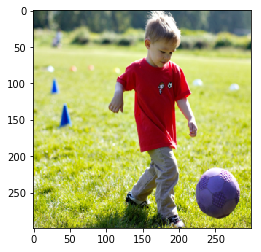

a little boy is running to kick a soccer ball .
a young boy kicking a soccer ball across a field .
a little boy kicking a soccer ball on a field .
a young boy kicking a soccer ball on a field .
a little boy kicking a soccer ball on a field .
a young boy in a soccer uniform kicking a soccer ball .
a little boy kicking a soccer ball on a field .
a little boy is playing frisbee in the grass .
a little boy kicking a soccer ball on a field .
a little boy is running with a frisbee .


In [0]:
!wget http://detivsporte.ru/images/football/222011121520.jpg
img = plt.imread('222011121520.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Another simple picture, and result is just good.

--2019-05-16 15:04:56--  https://topwar.ru/uploads/posts/2017-03/1488966684_f1.jpg
Resolving topwar.ru (topwar.ru)... 5.8.79.230
Connecting to topwar.ru (topwar.ru)|5.8.79.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46666 (46K) [image/jpeg]
Saving to: ‘1488966684_f1.jpg.16’

1488966684_f1.jpg.1 100%[===================>]  45.57K   257KB/s    in 0.2s    

2019-05-16 15:04:57 (257 KB/s) - ‘1488966684_f1.jpg.16’ saved [46666/46666]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


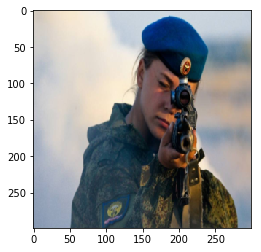

a man with a hat on his head out of a backpack .
a man with a hat and a tie on his head .
a man with a hat and hat is holding a cell phone .
a man is sitting on a bed looking at his phone
a man with a hat and a beard on a bed .
a person with a backpack is sitting on a bed .
a man with a beard is holding a pair of scissors .
a man with a hat and tie is holding a pair of scissors .
a woman with a hat on is holding a cell phone .
a person with a hat on sitting on a bed .


In [0]:
!wget https://topwar.ru/uploads/posts/2017-03/1488966684_f1.jpg
img = plt.imread('1488966684_f1.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Here I realized that training dataset does not contain some military photos. Still, network understood that it is a woman on the photo (it is not obvious because of hair, hat and face that closed by rifle)

--2019-05-16 15:05:08--  https://pnevmat24.ru/image/data/product/94/20/f4fae1bb78fb092cc22eb37f94bab23e.jpg
Resolving pnevmat24.ru (pnevmat24.ru)... 186.2.163.68
Connecting to pnevmat24.ru (pnevmat24.ru)|186.2.163.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374317 (366K) [image/jpeg]
Saving to: ‘f4fae1bb78fb092cc22eb37f94bab23e.jpg.15’

f4fae1bb78fb092cc22 100%[===================>] 365.54K   638KB/s    in 0.6s    

2019-05-16 15:05:10 (638 KB/s) - ‘f4fae1bb78fb092cc22eb37f94bab23e.jpg.15’ saved [374317/374317]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


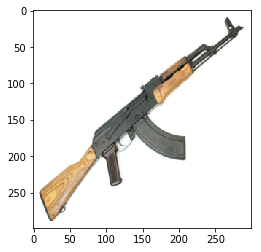

a large white teddy bear in a white shirt .
a stuffed animal sitting on a table .
a doughnut with sprinkles on it and a cup of coffee .
a large brown bear in a blue and white uniform .
a large bunch of stuffed animals sitting on a table .
a large bunch of stuffed animals on a table .
a close up of a person holding a doughnut
a white plate topped with a doughnut and a glass .
a person holding a bear in a #UNK# .
a piece of chocolate cake with a message on it .


In [0]:
!wget https://pnevmat24.ru/image/data/product/94/20/f4fae1bb78fb092cc22eb37f94bab23e.jpg
img = plt.imread('f4fae1bb78fb092cc22eb37f94bab23e.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()


for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Just to be sure that previous one is good and dataset actually does not contain photos of weapons and etc.

--2019-05-16 15:05:16--  https://www.dogbreedinfo.com/images20/DogWalking2.jpg
Resolving www.dogbreedinfo.com (www.dogbreedinfo.com)... 192.124.249.54
Connecting to www.dogbreedinfo.com (www.dogbreedinfo.com)|192.124.249.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51056 (50K) [image/jpeg]
Saving to: ‘DogWalking2.jpg.4’

DogWalking2.jpg.4   100%[===================>]  49.86K  --.-KB/s    in 0.03s   

2019-05-16 15:05:17 (1.41 MB/s) - ‘DogWalking2.jpg.4’ saved [51056/51056]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


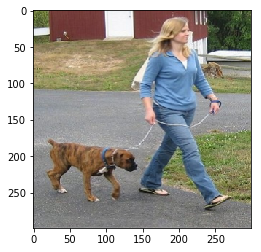

a woman is holding a dog and a frisbee .
a man in a hat is playing with a dog .
a dog is standing on the grass with a frisbee .
a dog is jumping up to catch a frisbee .
a dog with a frisbee in its mouth .
a woman is holding a dog on a leash .
a dog is running in the grass with a frisbee in his mouth .
a dog is running with a frisbee in its mouth .
a dog with a frisbee in its mouth .
a woman is holding a dog with a frisbee in its mouth .


In [0]:
!wget https://www.dogbreedinfo.com/images20/DogWalking2.jpg
img = plt.imread('DogWalking2.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

"a woman is holding a dog on a leash ." Good.

--2019-05-16 15:05:29--  https://usatiki.ru/wp-content/uploads/2017/11/chto-delat-esli-napala-sobaka-4.jpg
Resolving usatiki.ru (usatiki.ru)... 104.27.128.231, 104.27.129.231, 2606:4700:30::681b:81e7, ...
Connecting to usatiki.ru (usatiki.ru)|104.27.128.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71623 (70K) [image/jpeg]
Saving to: ‘chto-delat-esli-napala-sobaka-4.jpg.14’

chto-delat-esli-nap 100%[===================>]  69.94K  --.-KB/s    in 0.006s  

2019-05-16 15:05:29 (11.7 MB/s) - ‘chto-delat-esli-napala-sobaka-4.jpg.14’ saved [71623/71623]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


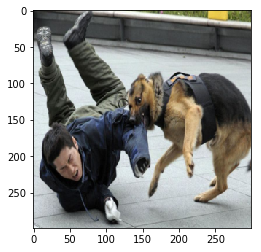

a dog with a hat on lays on a couch .
a dog laying on a couch with a remote control
a man is laying on a bed with a dog .
a dog is laying down on a bed .
a dog laying on the floor with a toy on his shoulder .
a man is laying down on a bed with a dog .
a dog laying on a couch next to a person
a man is sitting on a bed with a dog .
a dog laying on a bed with a dog on it .
a man is sitting on a bed with a dog .


In [0]:
!wget https://usatiki.ru/wp-content/uploads/2017/11/chto-delat-esli-napala-sobaka-4.jpg
img = plt.imread('chto-delat-esli-napala-sobaka-4.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Here more complex example. Here we can see also a person and a dog, but the main question is what are they doing. Network understood that man and god are interacting to each other, but seems that train dataset does not contain any agression (Azimov's rule, heh). That's why it is just "a dog laying on a bed with a dog on it"

--2019-05-16 15:05:48--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSs7ZPuo7k9YkR1IEAUBs7m7ITCR83-CEOCdIKhtbd6u5kjMwYd-A
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.195.138, 74.125.195.102, 74.125.195.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8412 (8.2K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcSs7ZPuo7k9YkR1IEAUBs7m7ITCR83-CEOCdIKhtbd6u5kjMwYd-A.16’

images?q=tbn:ANd9Gc 100%[===================>]   8.21K  --.-KB/s    in 0.001s  

2019-05-16 15:05:48 (5.69 MB/s) - ‘images?q=tbn:ANd9GcSs7ZPuo7k9YkR1IEAUBs7m7ITCR83-CEOCdIKhtbd6u5kjMwYd-A.16’ saved [8412/8412]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


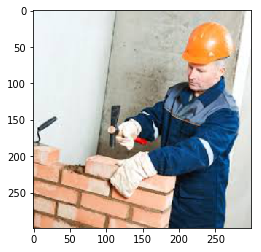

a man in a suit is sitting on a bench with a dog .
a man is doing a trick on a skateboard .
a man in a suit and tie is standing next to a fire hydrant .
a man in a suit and tie is sitting on a bench .
a man in a suit and tie is holding a skateboard .
a man in a suit and tie standing next to a woman .
a man in a suit and tie is sitting on a bench .
a man in a suit and a hat on a skateboard .
a man in a helmet is sitting down in a concrete step .
a man in a suit and tie holding a bat .


In [0]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSs7ZPuo7k9YkR1IEAUBs7m7ITCR83-CEOCdIKhtbd6u5kjMwYd-A
img = plt.imread('images?q=tbn:ANd9GcSs7ZPuo7k9YkR1IEAUBs7m7ITCR83-CEOCdIKhtbd6u5kjMwYd-A')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Here we can see just pretty bad result. Network understood that this is a man in helmet, but did not see a uniform and that this man is a builder.

--2019-05-16 15:06:17--  https://www.indiewire.com/wp-content/uploads/2014/06/californication-season-7-finale.R.jpg?w=780
Resolving www.indiewire.com (www.indiewire.com)... 192.0.66.2
Connecting to www.indiewire.com (www.indiewire.com)|192.0.66.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134172 (131K) [image/jpeg]
Saving to: ‘californication-season-7-finale.R.jpg?w=780.13’

californication-sea 100%[===================>] 131.03K  --.-KB/s    in 0.07s   

2019-05-16 15:06:17 (1.72 MB/s) - ‘californication-season-7-finale.R.jpg?w=780.13’ saved [134172/134172]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


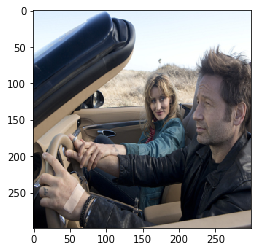

a man sitting on a bench with a cell phone .
a man sitting on a chair next to a cat .
a woman sitting on a chair with a small dog .
a woman sitting on a seat looking at a cell phone .
a woman sitting on a chair looking at her cell phone .
a man is sitting on a bench with a laptop
a man sitting on a bench with his head on the back of a car .
a man sitting on a couch with a laptop .
a man sitting on a chair holding a cell phone .
a man sitting on a bench with a woman on a cell phone .


In [0]:
!wget https://www.indiewire.com/wp-content/uploads/2014/06/californication-season-7-finale.R.jpg?w=780
img = plt.imread('californication-season-7-finale.R.jpg?w=780')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Another bad result, maybe because of pretty complex angle of the photo. But since it understood that here "a man sitting on a bench with his head on the back of a car". Good, but not so good as I expected :(

--2019-05-16 16:00:44--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRPelcoQ2RQrmS4s9ZxcXonwiRpL2wi-qp-IMoW0OSAXUBkCmWZdw
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.195.139, 74.125.195.100, 74.125.195.113, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9483 (9.3K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcRPelcoQ2RQrmS4s9ZxcXonwiRpL2wi-qp-IMoW0OSAXUBkCmWZdw’

images?q=tbn:ANd9Gc 100%[===================>]   9.26K  --.-KB/s    in 0.001s  

2019-05-16 16:00:44 (6.79 MB/s) - ‘images?q=tbn:ANd9GcRPelcoQ2RQrmS4s9ZxcXonwiRpL2wi-qp-IMoW0OSAXUBkCmWZdw’ saved [9483/9483]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


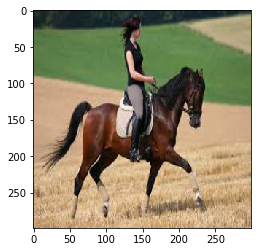

a woman riding a horse on a field .
a man riding a horse on a dirt field .
a woman riding a horse on a dirt field .
a woman is riding a horse in a field .
a woman is riding a horse on a field .
a man is riding a horse in a field .
a woman is riding a horse on a dirt track .
a man is riding a horse in a field .
a woman is riding a horse on a field .
a woman is riding a horse on the grass .


In [0]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRPelcoQ2RQrmS4s9ZxcXonwiRpL2wi-qp-IMoW0OSAXUBkCmWZdw
img = plt.imread('images?q=tbn:ANd9GcRPelcoQ2RQrmS4s9ZxcXonwiRpL2wi-qp-IMoW0OSAXUBkCmWZdw')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Just simple photo and simple good result.

--2019-05-16 15:54:41--  https://www.ridus.ru/images/2017/1/3/523399/in_article_d41845cf05.png
Resolving www.ridus.ru (www.ridus.ru)... 185.246.116.42
Connecting to www.ridus.ru (www.ridus.ru)|185.246.116.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322924 (315K) [image/png]
Saving to: ‘in_article_d41845cf05.png’

in_article_d41845cf 100%[===================>] 315.36K   589KB/s    in 0.5s    

2019-05-16 15:54:43 (589 KB/s) - ‘in_article_d41845cf05.png’ saved [322924/322924]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


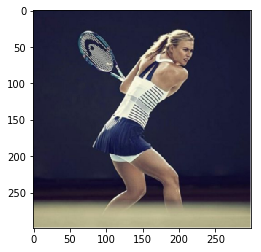

a tennis player is in the air with a racket .
a woman is swinging a tennis racket on a court .
a tennis player is returning a serve .
a tennis player is swinging at a ball .
a woman in a white dress and a tennis court with a tennis racket .
a woman is swinging a tennis racket .
a tennis player is swinging a racket at a ball .
a woman in a tennis skirt is on a tennis court .
a woman is playing tennis on a court .
a tennis player is playing tennis on the court .


In [0]:
!wget https://www.ridus.ru/images/2017/1/3/523399/in_article_d41845cf05.png
img = plt.imread('in_article_d41845cf05.png')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Good result, woman that playng tennis on a court. Maria Sharapova is just pure beauty.

--2019-05-16 15:56:11--  https://cs8.pikabu.ru/post_img/big/2016/01/26/9/1453820520190837269.jpg
Resolving cs8.pikabu.ru (cs8.pikabu.ru)... 151.236.99.60
Connecting to cs8.pikabu.ru (cs8.pikabu.ru)|151.236.99.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252778 (247K) [image/jpeg]
Saving to: ‘1453820520190837269.jpg’

1453820520190837269 100%[===================>] 246.85K   465KB/s    in 0.5s    

2019-05-16 15:56:13 (465 KB/s) - ‘1453820520190837269.jpg’ saved [252778/252778]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


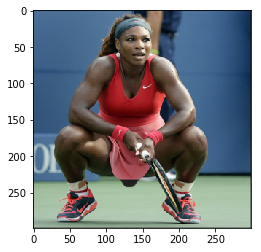

a man is playing frisbee on a blue tennis court .
a man is playing tennis on a white surface .
a person is playing with a tennis racket .
a man is on a tennis court with a tennis racket .
a man is playing tennis on a court .
a man is playing tennis on a court .
a man in a white shirt and a white shirt holding a tennis racket .
a man in a red shirt is holding a tennis racket
a man is holding a tennis racket in his hands .
a man is holding a tennis racket in a tennis court .


In [0]:
!wget https://cs8.pikabu.ru/post_img/big/2016/01/26/9/1453820520190837269.jpg
img = plt.imread('1453820520190837269.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Here the newtwork failed. Here one of the Williams sisters, but it decided that it is a man in most cases. Thats the serious problem of such systems and somehow it need to change the man/woman to the person in cases that might be wrong or offensive to someone.

--2019-05-16 16:16:48--  https://www.pravmir.ru/wp-content/uploads/2017/09/3H4B9704italiano.jpg
Resolving www.pravmir.ru (www.pravmir.ru)... 77.247.244.118
Connecting to www.pravmir.ru (www.pravmir.ru)|77.247.244.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1365205 (1.3M) [image/jpeg]
Saving to: ‘3H4B9704italiano.jpg’

3H4B9704italiano.jp 100%[===================>]   1.30M   675KB/s    in 2.0s    

2019-05-16 16:16:52 (675 KB/s) - ‘3H4B9704italiano.jpg’ saved [1365205/1365205]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


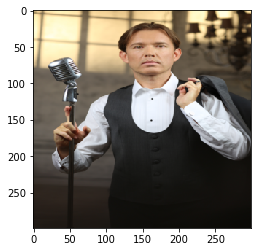

a man in a white shirt and tie holding a camera .
a man in a white shirt and tie with a tie .
a man with a beard is holding a toothbrush in his mouth .
a man in a suit is holding a toothbrush
a man is holding a glass of wine .
a man in a white shirt and tie sitting on a bed .
a man is holding a cell phone to his ear .
a man is standing in front of a mirror taking a picture of himself .
a man in a blue shirt is holding a white toothbrush .
a man is holding a cell phone to his ear .


In [0]:
!wget https://www.pravmir.ru/wp-content/uploads/2017/09/3H4B9704italiano.jpg
img = plt.imread('3H4B9704italiano.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Man in suit, but what about microphone? Singer? I did not satisfied :(. But since, result is not so bad.

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)